In [105]:
from region_detection import *
from commonfunctions import *

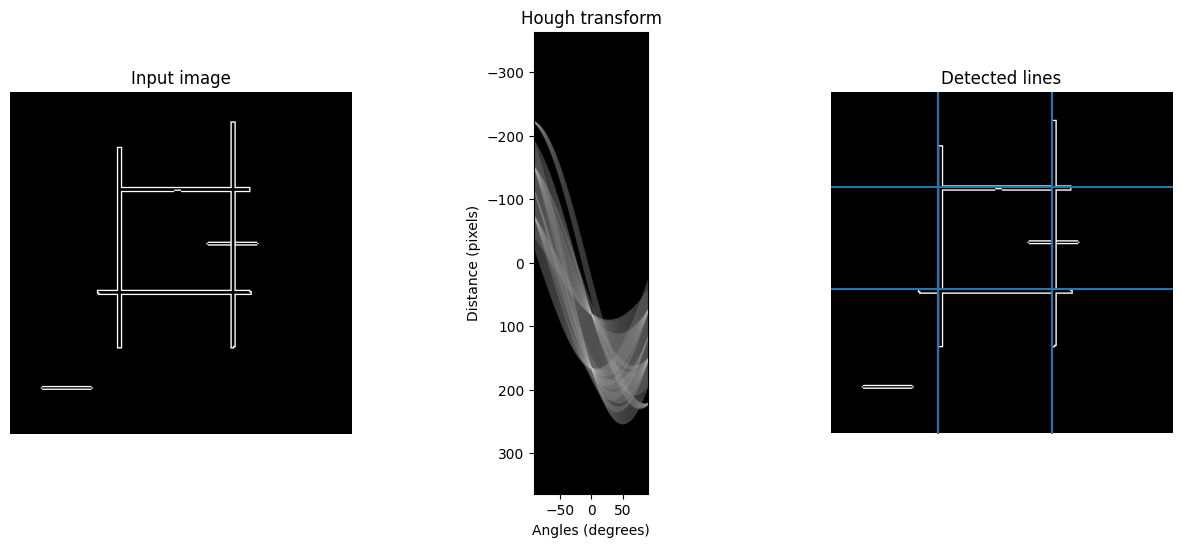

In [106]:
cow_select=io.imread('images-to-be-tested/test1.png')
cow_orig=io.imread('images-to-be-tested/16.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

In [107]:
# io.imshow(binary_mask_test)

In [108]:
def MSD(target_patch, exemplar_patch, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')
    if np.sum(M_bar)==0:
        return float('inf')
    else:
     msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)/np.sum(M_bar)
     return msd
    # return msd

    # msd=np.sum((M_bar*target_patch - M_bar*exemplar_patch)**2)

    

def SMD (target_patch, exemplar_patch, binary_mask, M_bar):
    # if not np.isin(1,M_bar):
    #     return float('inf')
    if np.sum(M_bar)==0:
        return float('inf')
    if np.sum(binary_mask)==0:
        return float('inf')
    target_existing_avg= np.sum(M_bar * target_patch)/np.sum(M_bar)
    exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)/np.sum(binary_mask)
    smd= (target_existing_avg-exemplar_fill_avg)**2
    return smd 

    # target_existing_avg= np.sum(M_bar * target_patch)
    # exemplar_fill_avg = np.sum(binary_mask* exemplar_patch)
    # smd= (target_existing_avg-exemplar_fill_avg)**2
    # return smd 

def findBestsubPatch(target_patch, exemplar_patches, binary_mask, M_bar):
    best_patch = exemplar_patches[int(len(exemplar_patches)/2)]
    min_combined_error = float('inf')

    for other_patch in exemplar_patches:
        current_error = MSD((rgb2gray(target_patch)*255).astype('uint8'), (rgb2gray(other_patch)*255).astype('uint8'), M_bar) + SMD((rgb2gray(target_patch)*255).astype('uint8'), (rgb2gray(other_patch)*255).astype('uint8'), binary_mask, M_bar)
        if current_error < min_combined_error:
            best_patch = other_patch
            min_combined_error = current_error

    return best_patch


def findBestFullPatch(target_patches, exemplar_patches,binary_mask_patches, M_bar_patches):
    cp_target_patches = np.copy(target_patches)
    for i,target_patch in enumerate(target_patches):
        best_sub_patch=findBestsubPatch(target_patch,exemplar_patches,binary_mask_patches[i],M_bar_patches[i])
        
        cp_target_patches[i][binary_mask_patches[i] == 1] = best_sub_patch[binary_mask_patches[i] == 1]
    return cp_target_patches


In [109]:
def main(img,binary_mask, overlap=50,patch_size=50):
    

    white_pixels = np.sum(binary_mask == 1)
    black_pixels = np.sum(binary_mask == 0)

# Calculate the ratio
    ratio = white_pixels / (white_pixels + black_pixels)
    if ratio < 0.15:
        overlap = 64
        patch_size =64
    elif ratio >0.3:
        overlap = 80
        patch_size =80
    else:
        overlap = 32
        patch_size =32

    img_in_patches= [img[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0]-patch_size+1, overlap) for j in range(0,img.shape[1]-patch_size+1, overlap) ]
    full_binary_mask_patches = [binary_mask[i:i+patch_size,j:j+patch_size] for i in range(0,img.shape[0]-patch_size+1, overlap) for j in range(0,img.shape[1]-patch_size+1, overlap) ]
    #if the patch contains a single 1 then it's subset of the target patch so mark it with 1 in the bit map
    # bit_map=[ 1 if np.isin(1,full_binary_mask_patches[i]) else 0 for i in range(len(full_binary_mask_patches))]

    target_indices=[]
    exemplar_indices=[]
    binary_mask_patches= []
    target_patches=[]
    exemplar_patches=[]
    target_patch_counter=0
    patches_per_row = (img.shape[0] - patch_size) // overlap + 1
    patches_per_col = (img.shape[1] - patch_size) // overlap + 1
    for i, binary_mask_patch in enumerate(full_binary_mask_patches):

        start_row = (i // patches_per_row) * overlap
        start_col = (i % patches_per_row) * overlap
        if np.isin(1,binary_mask_patch):
            # This means that it is a target patch
            target_indices.append((target_patch_counter,start_row,start_col))
            binary_mask_patches.append(full_binary_mask_patches[i])
            target_patches.append(img_in_patches[i])
            target_patch_counter+=1
            # binary_mask_patches.append(binary_mask[start_row:start_row+patch_size])

        else:
            exemplar_indices.append((i, start_row, start_col))
            exemplar_patches.append(img_in_patches[i])


    # M_bar_patches=[np.where((binary_mask_patches[i]==0)|(binary_mask_patches[i]==1), binary_mask_patches[i]^1, binary_mask_patches) for i in range(len(binary_mask_patches))]
    M_bar_patches=[1-binary_mask_patches[i] for i in range(len(binary_mask_patches))]
    #TO-DO: call implemented functions
    new_target_patches=findBestFullPatch(target_patches,exemplar_patches,binary_mask_patches,M_bar_patches)
    print(len(new_target_patches))
    print(len(target_patches))
    print("new_target_patches",new_target_patches[0])
    print(new_target_patches[1])

    new_img= np.copy(img)
    for target_index, start_row, start_col in target_indices:
        print(target_index)
        new_img[start_row: start_row+patch_size, start_col:start_col+patch_size]=new_target_patches[target_index]
    
    return new_img

    # list of tuples (i,start_row,start_col)
    '''
    for target_index, start_row, start_col in target_indices:
        img[start_row:start_row+patch_size , start_col: start_col+patch_size]=cp_target_patches[target_index]
        start_row = (i // (img.shape[0] // patch_size)) * patch_size
        start_col = (i % (img.shape[1] // patch_size)) * patch_size
    
    '''





In [110]:
binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')


Ratio of white to black pixels: 0.098175048828125
4
4
new_target_patches [[[108 126 138]
  [109 127 139]
  [107 125 137]
  ...
  [ 69  28  42]
  [ 71  35  49]
  [ 63  30  44]]

 [[114 127 135]
  [112 125 133]
  [115 125 134]
  ...
  [ 73  32  46]
  [ 73  35  48]
  [ 55  22  35]]

 [[ 86 100 113]
  [ 86  98 110]
  [ 78  90 102]
  ...
  [ 74  33  49]
  [ 71  30  44]
  [ 44  12  24]]

 ...

 [[222 212 211]
  [228 219 218]
  [211 202 200]
  ...
  [194 183 181]
  [224 212 212]
  [224 214 213]]

 [[229 221 219]
  [207 199 196]
  [235 232 227]
  ...
  [233 223 221]
  [231 221 220]
  [221 213 211]]

 [[233 225 223]
  [228 220 218]
  [226 220 215]
  ...
  [222 212 211]
  [221 213 211]
  [223 215 213]]]
[[[ 74  38  50]
  [ 72  36  50]
  [ 72  38  52]
  ...
  [ 80   9  45]
  [139  52  94]
  [145  54  97]]

 [[ 74  38  50]
  [ 73  37  50]
  [ 67  35  48]
  ...
  [106  31  68]
  [145  58 101]
  [150  57 101]]

 [[ 73  37  51]
  [ 73  39  53]
  [ 70  39  51]
  ...
  [141  64 102]
  [146  59 102]
  [

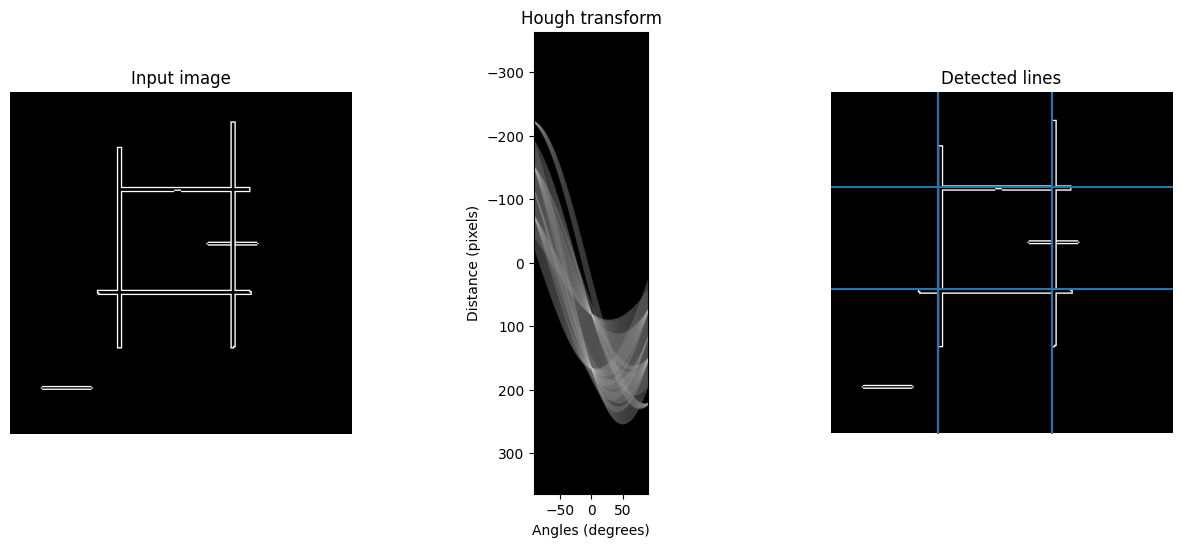

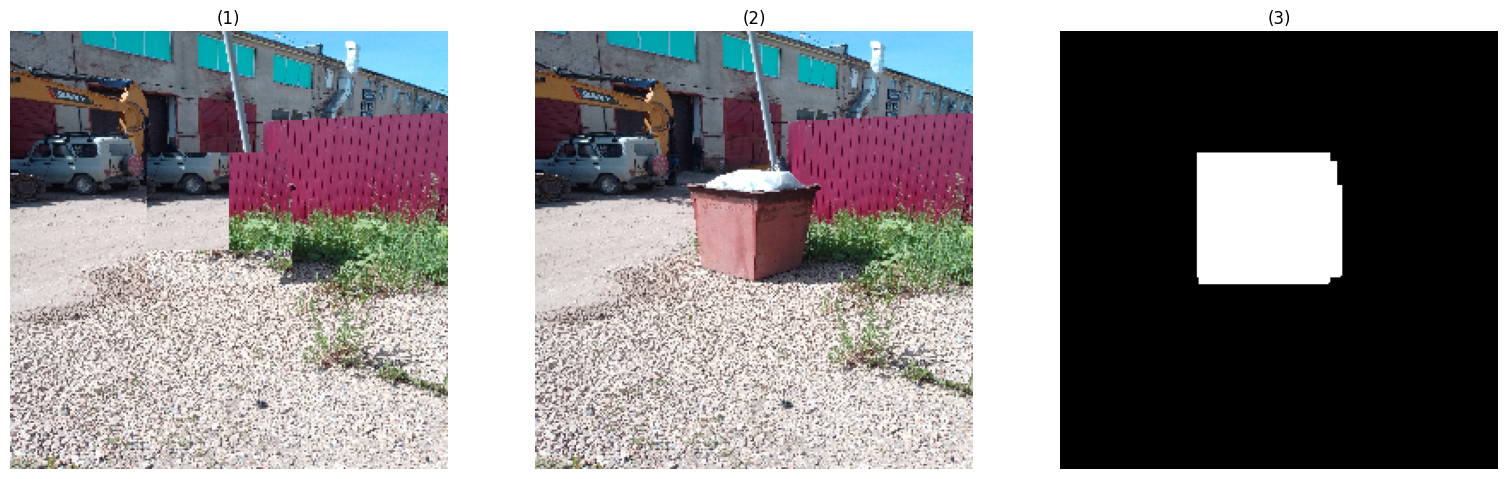

In [111]:
cow_select=io.imread('images-to-be-tested/test1.png')
cow_orig=io.imread('images-to-be-tested/16.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection class
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test)
show_images([newImg,grayLevelImg,   binary_mask_test])


Ratio of white to black pixels: 0.0977783203125
6
6
new_target_patches [[[ 70  81  80]
  [ 76  87  84]
  [ 77  87  84]
  ...
  [170 175 177]
  [170 174 175]
  [182 186 187]]

 [[ 25  23  18]
  [ 27  23  17]
  [ 35  33  21]
  ...
  [ 83  91  93]
  [ 93 102 102]
  [128 136 138]]

 [[ 98  86  70]
  [106  90  74]
  [119 106  87]
  ...
  [134 143 142]
  [132 141 140]
  [132 140 142]]

 ...

 [[ 26  45  19]
  [ 24  33  12]
  [ 41  68  36]
  ...
  [137 133 122]
  [135 131 120]
  [121 121 111]]

 [[ 11  25   5]
  [ 16  23   5]
  [ 12  27   5]
  ...
  [144 137 127]
  [144 140 129]
  [136 134 122]]

 [[ 18  31  11]
  [ 19  23   7]
  [ 20  30   6]
  ...
  [139 133 121]
  [146 139 127]
  [144 139 127]]]
[[[185 190 193]
  [203 210 211]
  [222 227 228]
  ...
  [228 229 231]
  [225 226 228]
  [225 229 230]]

 [[139 149 151]
  [164 174 176]
  [188 195 198]
  ...
  [235 236 238]
  [225 227 226]
  [223 227 228]]

 [[132 142 143]
  [136 144 146]
  [136 145 144]
  ...
  [226 230 231]
  [222 226 227]
  [21

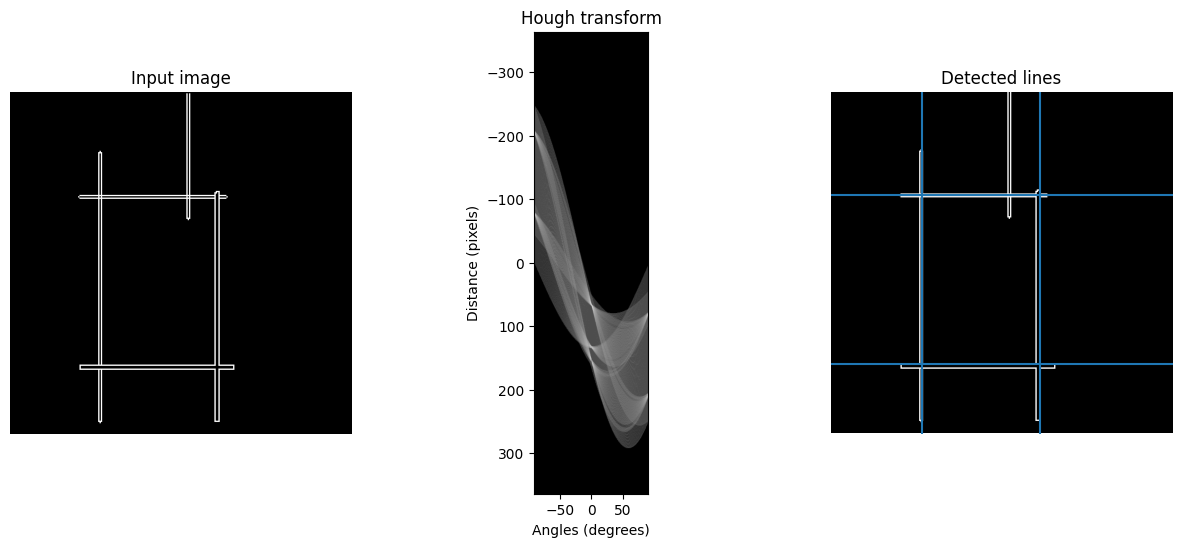

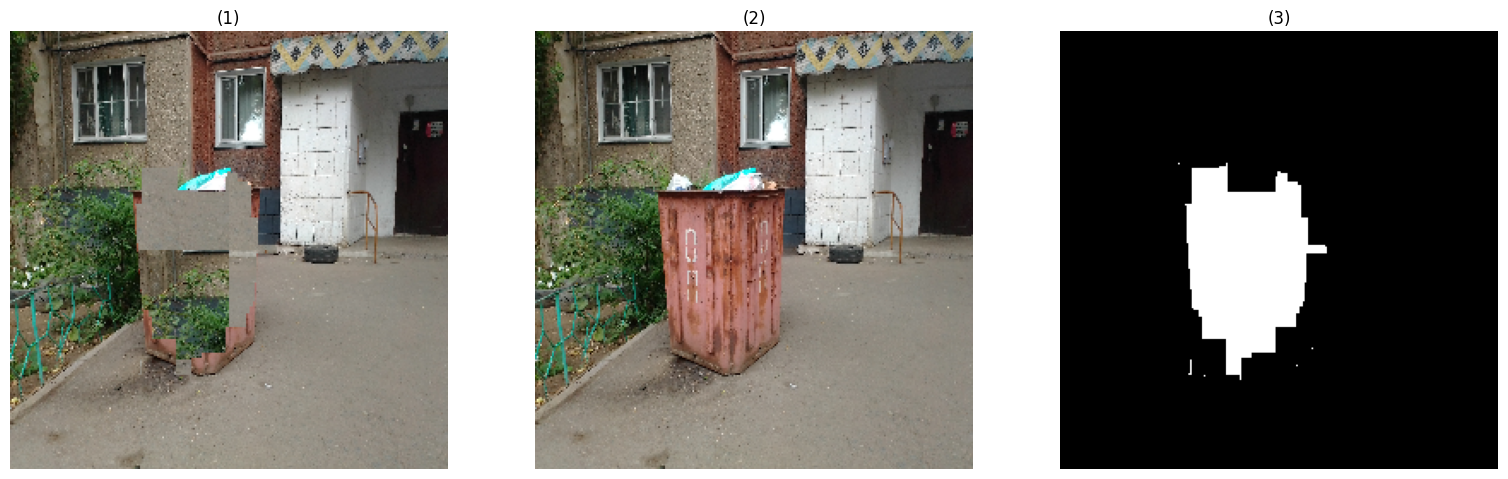

In [112]:
cow_select=io.imread('images-to-be-tested/garbage_with_selection.png')
cow_orig=io.imread('images-to-be-tested/garbage.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
# Calculate the ratio
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")
newImg= main(grayLevelImg,binary_mask_test)
show_images([newImg,grayLevelImg,   binary_mask_test])





Ratio of white to black pixels: 0.3027496337890625
4
4
new_target_patches [[[ 60  74  47]
  [ 62  74  51]
  [ 70  82  57]
  ...
  [249 249 249]
  [158 160 149]
  [131 131 126]]

 [[ 61  76  47]
  [ 70  85  60]
  [ 62  71  52]
  ...
  [195 193 194]
  [225 225 226]
  [210 210 213]]

 [[ 56  73  45]
  [ 67  85  51]
  [ 99 125  85]
  ...
  [223 221 224]
  [223 222 228]
  [187 186 198]]

 ...

 [[145 145  93]
  [148 146  90]
  [165 164 108]
  ...
  [163 156 109]
  [177 172 128]
  [176 168 124]]

 [[155 153 101]
  [150 149  95]
  [154 153  98]
  ...
  [167 164 113]
  [138 127  82]
  [144 152  94]]

 [[136 139  85]
  [154 158 106]
  [142 143  92]
  ...
  [163 161 113]
  [134 130  82]
  [124 127  74]]]
[[[118 117 112]
  [ 89  89  88]
  [ 85  84  77]
  ...
  [116 118  94]
  [118 117  97]
  [ 90  91  75]]

 [[252 251 254]
  [232 230 236]
  [234 233 237]
  ...
  [100 101  80]
  [118 116  96]
  [118 118  94]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [108 109  85]
  [100 102  82]
  

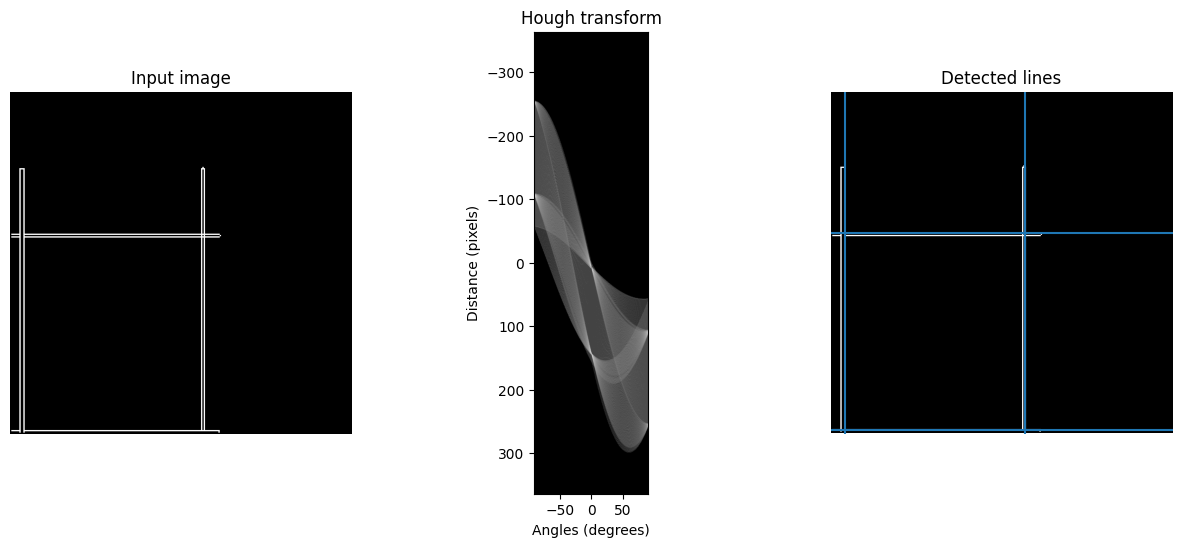

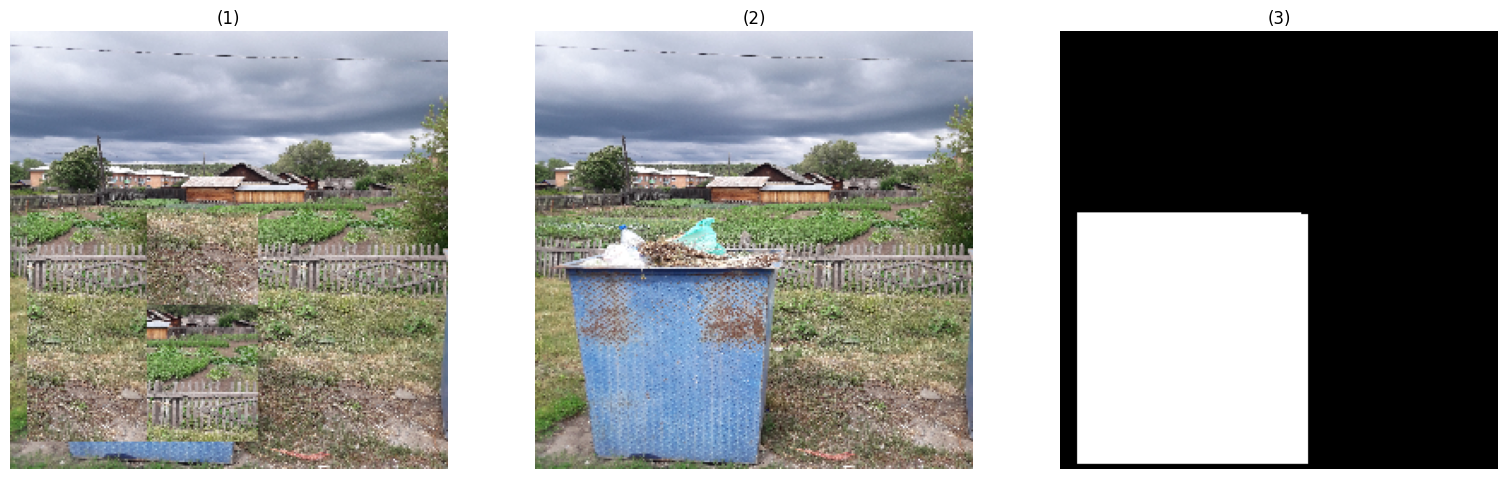

In [113]:
cow_select=io.imread('images-to-be-tested/garb2_with_sel.png')
cow_orig=io.imread('images-to-be-tested/garb2.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]
grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test)
show_images([newImg,grayLevelImg,   binary_mask_test])



In [114]:
# cow_select=io.imread('images-to-be-tested/test3.png')
# cow_orig=io.imread('images-to-be-tested/ship.jpg')

# target_img_size = (256, 256)

# cow_sel_resize = cv2.resize(cow_select, target_img_size)
# cow_sel_conversion = cow_sel_resize[:,:,:3]
# cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # # Create an instance of the RegionDetection overlap=32
# region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
# region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

# binary_mask_test=binary_mask_test[:,:,0]
# grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
# white_pixels = np.sum(binary_mask_test == 1)
# black_pixels = np.sum(binary_mask_test == 0)

# # Calculate the ratio
# ratio = white_pixels / (white_pixels + black_pixels)
# print(f"Ratio of white to black pixels: {ratio}")
# newImg= main(grayLevelImg,binary_mask_test)
# show_images([newImg,grayLevelImg,   binary_mask_test])



Ratio of white to black pixels: 0.21588134765625
29
29
new_target_patches [[[166 168 116]
  [163 166 111]
  [167 171 113]
  ...
  [182 184 110]
  [182 184 109]
  [184 186 112]]

 [[171 175 116]
  [167 171 111]
  [170 175 112]
  ...
  [186 188 112]
  [185 188 111]
  [184 186 111]]

 [[176 181 118]
  [170 175 111]
  [172 177 112]
  ...
  [185 187 112]
  [182 185 109]
  [179 181 106]]

 ...

 [[169 173 106]
  [167 169 104]
  [168 169 105]
  ...
  [216 187 158]
  [190 163 134]
  [171 174 108]]

 [[160 165 100]
  [162 166 103]
  [166 168 106]
  ...
  [210 182 155]
  [197 171 144]
  [166 171 106]]

 [[152 156  95]
  [156 159  98]
  [163 164 105]
  ...
  [177 184 117]
  [178 184 119]
  [166 171 107]]]
[[[182 181 116]
  [184 182 118]
  [185 184 119]
  ...
  [182 183 115]
  [182 183 114]
  [183 184 116]]

 [[182 183 113]
  [184 184 116]
  [185 185 117]
  ...
  [180 181 111]
  [181 182 112]
  [184 185 115]]

 [[185 187 115]
  [185 186 117]
  [185 186 116]
  ...
  [179 181 109]
  [182 183 111]
  

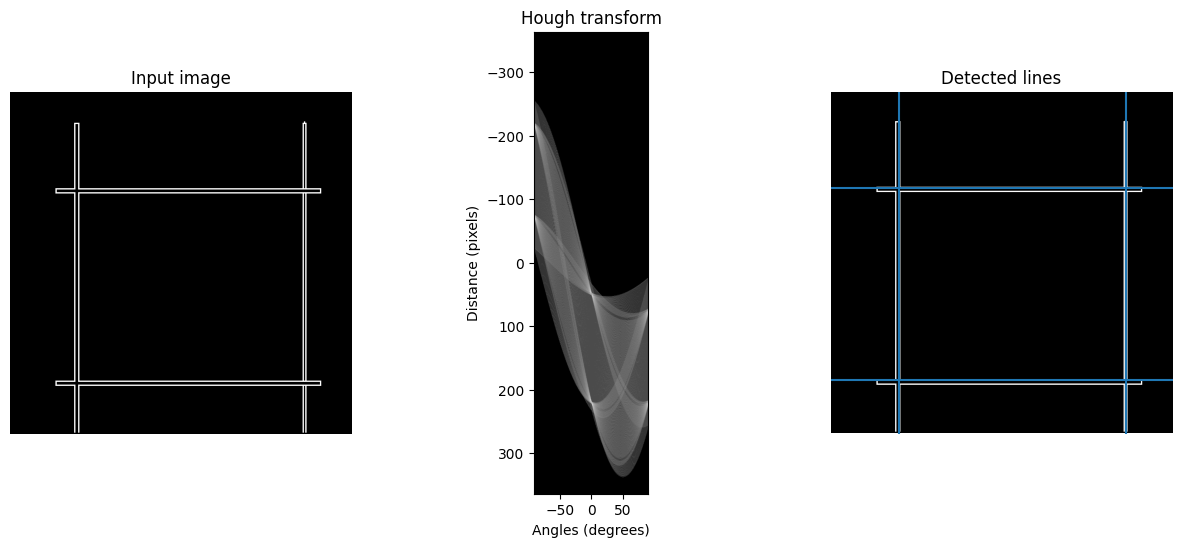

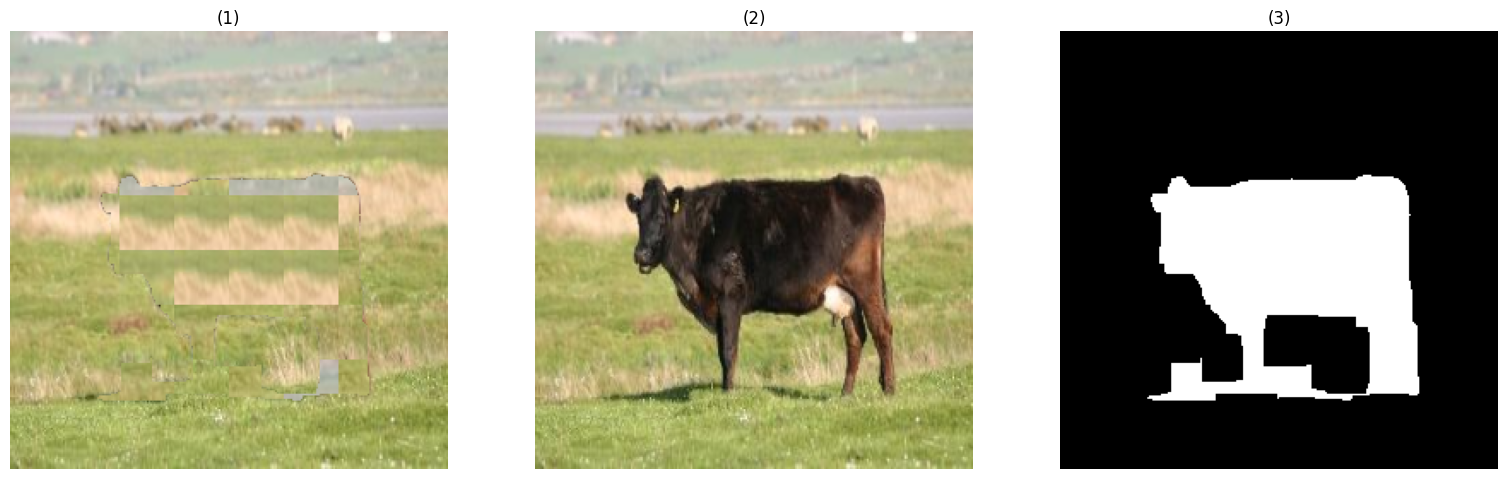

In [115]:
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
cow_orig=io.imread('images-to-be-tested/cow.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test)
show_images([newImg,grayLevelImg,   binary_mask_test])




Ratio of white to black pixels: 0.05242919921875
6
6
new_target_patches [[[142 193 250]
  [142 193 250]
  [142 193 250]
  ...
  [ 21  26  32]
  [ 18  23  31]
  [ 21  25  34]]

 [[143 194 251]
  [143 194 251]
  [143 194 251]
  ...
  [ 17  21  30]
  [ 19  23  32]
  [ 34  38  49]]

 [[143 194 251]
  [143 194 251]
  [143 194 251]
  ...
  [ 41  44  55]
  [ 39  43  54]
  [ 58  62  74]]

 ...

 [[100 136 149]
  [ 96 131 145]
  [ 93 128 141]
  ...
  [ 23  36  29]
  [ 18  31  23]
  [ 30  44  34]]

 [[108 141 150]
  [105 138 147]
  [101 135 143]
  ...
  [ 20  33  24]
  [ 11  24  15]
  [ 21  34  24]]

 [[101 135 137]
  [102 135 137]
  [102 134 137]
  ...
  [106 119  73]
  [121 134  88]
  [155 167 120]]]
[[[12 20 28]
  [21 28 38]
  [22 28 39]
  ...
  [ 8 10  9]
  [10 12 11]
  [12 14 13]]

 [[39 46 56]
  [19 25 37]
  [18 24 37]
  ...
  [ 7  9  8]
  [10 12 12]
  [10 12 11]]

 [[16 22 34]
  [19 25 39]
  [ 7 13 28]
  ...
  [ 7  9  8]
  [10 12 12]
  [ 9 11 10]]

 ...

 [[20 32 17]
  [37 49 32]
  [44 57

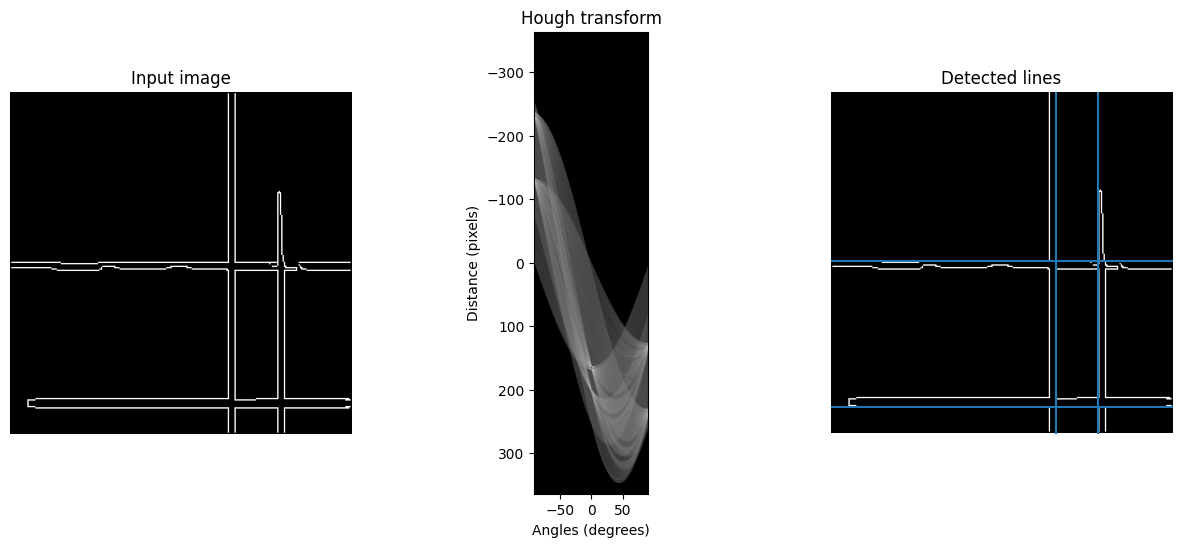

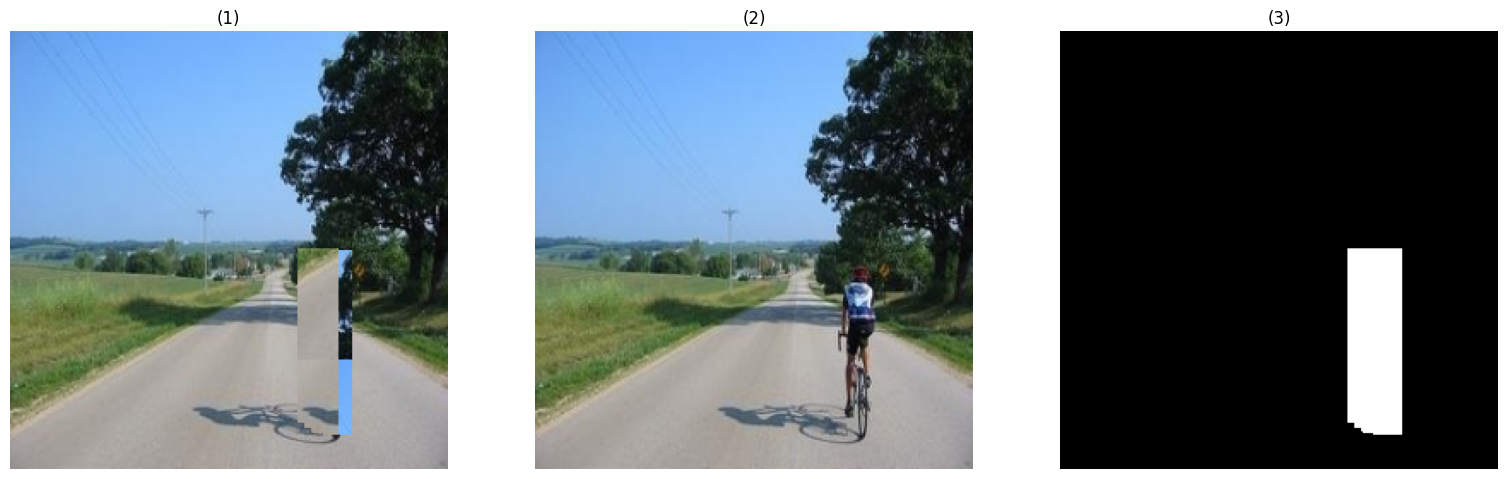

In [127]:
cow_select=io.imread('images-to-be-tested/bikeSel.png')
cow_orig=io.imread('images-to-be-tested/bike.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,32,32)
show_images([newImg,grayLevelImg,   binary_mask_test])


Ratio of white to black pixels: 0.0279541015625
2
2
new_target_patches [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 255 254]
  [253 255 254]
  [253 255 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 255 254]
  [253 255 254]
  [253 255 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 255 254]
  [253 255 254]
  [253 255 254]]

 ...

 [[101 108  34]
  [114 119  46]
  [116 121  51]
  ...
  [119 109  75]
  [110 101  62]
  [ 78  70  30]]

 [[122 128  56]
  [113 117  45]
  [ 93  96  28]
  ...
  [118 111  69]
  [102  95  49]
  [ 89  82  39]]

 [[117 122  52]
  [112 115  45]
  [ 97 100  35]
  ...
  [ 85  78  30]
  [ 83  77  26]
  [ 95  89  41]]]
[[[107 109  42]
  [125 125  61]
  [127 127  67]
  ...
  [107 101  48]
  [117 112  55]
  [126 121  63]]

 [[114 115  49]
  [123 123  61]
  [120 120  61]
  ...
  [135 131  70]
  [137 134  69]
  [139 135  69]]

 [[106 106  42]
  [112 110  50]
  [108 106  50]
  ...
  [132 129  62]
  [128 125  55]
  [12

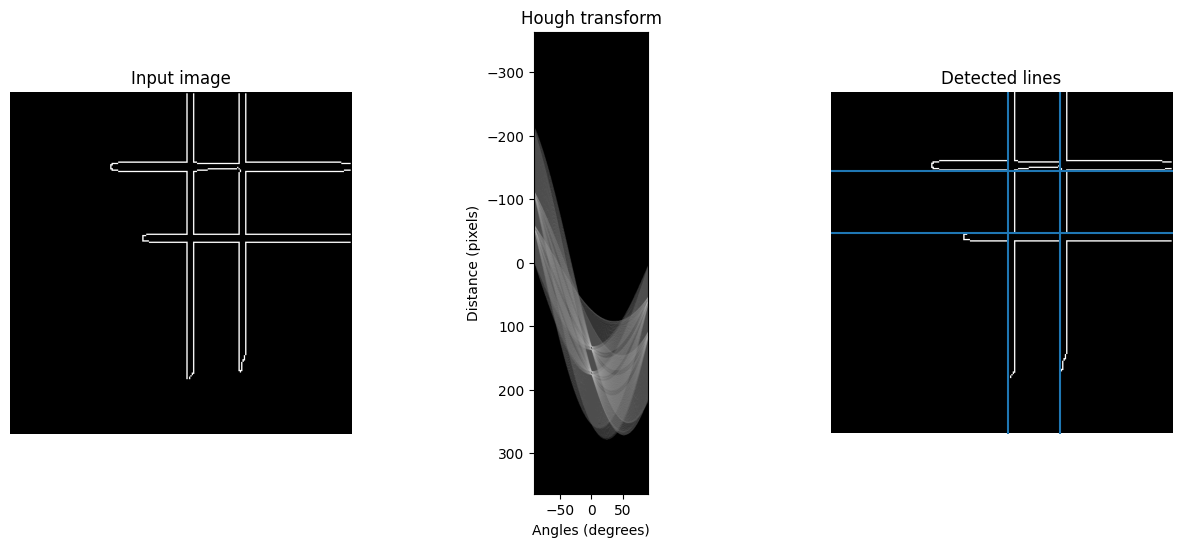

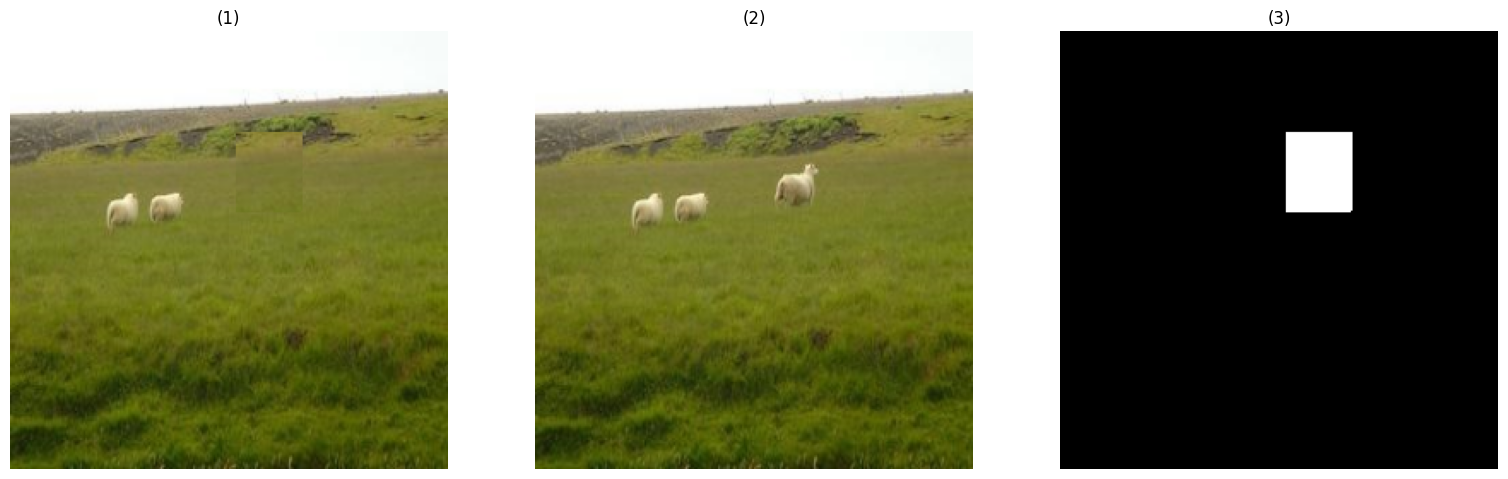

In [128]:
cow_select=io.imread('images-to-be-tested/animalsel.png')
cow_orig=io.imread('images-to-be-tested/animal.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,32,32)
show_images([newImg,grayLevelImg,   binary_mask_test])


Ratio of white to black pixels: 0.0244293212890625
5
5
new_target_patches [[[ 77  89  67]
  [ 68  82  61]
  [101 117  92]
  ...
  [110 133 117]
  [115 139 123]
  [126 152 134]]

 [[115 127 103]
  [ 92 106  83]
  [ 75  92  67]
  ...
  [122 145 129]
  [126 150 134]
  [120 147 128]]

 [[160 172 149]
  [111 125 102]
  [ 79  96  71]
  ...
  [106 129 113]
  [118 142 126]
  [110 137 118]]

 ...

 [[111 136  97]
  [100 124  86]
  [104 128  93]
  ...
  [ 88  94  80]
  [ 38  44  30]
  [ 23  30  17]]

 [[ 97 121  81]
  [109 132  95]
  [101 125  90]
  ...
  [186 227 163]
  [ 33  38  24]
  [ 16  21   9]]

 [[ 91 116  76]
  [ 96 119  80]
  [108 134  96]
  ...
  [158 198 127]
  [ 38  42  28]
  [ 16  19   8]]]
[[[ 72  97  55]
  [ 80 103  64]
  [ 99 124  87]
  ...
  [ 78 105  63]
  [ 35  39  28]
  [ 19  21  10]]

 [[ 95 120  78]
  [124 150 108]
  [111 139  99]
  ...
  [ 82 108  65]
  [ 37  41  30]
  [ 45  48  37]]

 [[ 88 114  70]
  [109 135  93]
  [123 151 111]
  ...
  [111 137  94]
  [ 93 121  76]
  

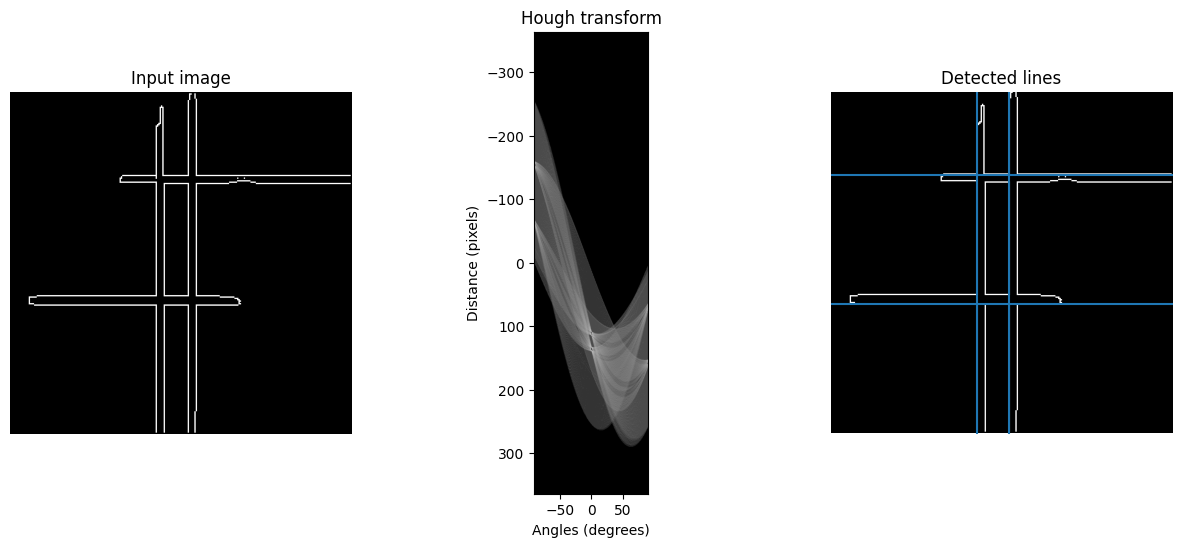

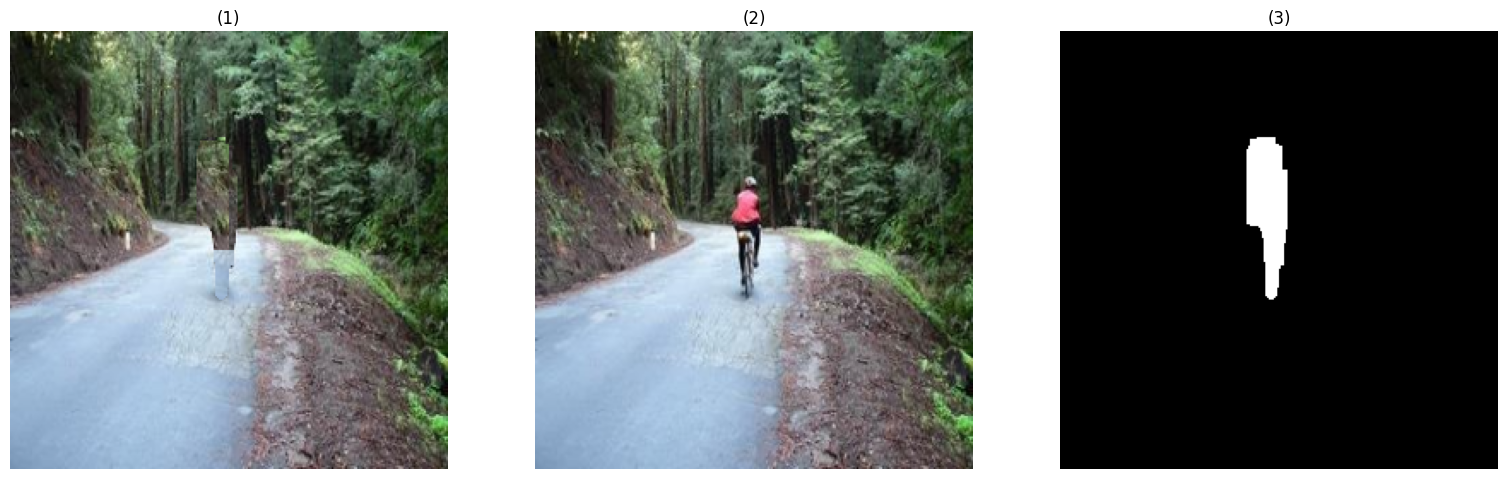

In [132]:
cow_select=io.imread('images-to-be-tested/bike2sel.png')
cow_orig=io.imread('images-to-be-tested/bike2.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,32,32)
show_images([newImg,grayLevelImg,   binary_mask_test])


Ratio of white to black pixels: 0.0640869140625
6
6
new_target_patches [[[179 180 174]
  [180 181 175]
  [180 181 175]
  ...
  [192 193 185]
  [192 193 186]
  [193 194 188]]

 [[177 180 173]
  [179 182 175]
  [178 181 174]
  ...
  [191 193 185]
  [191 193 185]
  [193 194 186]]

 [[177 180 173]
  [178 181 174]
  [177 180 173]
  ...
  [190 193 184]
  [190 193 184]
  [191 194 185]]

 ...

 [[151 157 143]
  [151 156 142]
  [151 157 143]
  ...
  [153 158 135]
  [153 158 135]
  [152 157 135]]

 [[154 158 144]
  [153 157 143]
  [154 158 144]
  ...
  [153 159 135]
  [153 158 135]
  [152 157 134]]

 [[156 158 145]
  [154 156 143]
  [156 158 144]
  ...
  [154 158 135]
  [153 158 135]
  [154 159 136]]]
[[[193 194 186]
  [193 194 186]
  [194 195 187]
  ...
  [214 216 205]
  [214 217 205]
  [215 217 206]]

 [[192 195 186]
  [192 194 186]
  [193 194 186]
  ...
  [213 215 204]
  [214 216 205]
  [214 216 205]]

 [[192 195 186]
  [191 194 185]
  [191 194 185]
  ...
  [213 215 204]
  [213 215 204]
  [21

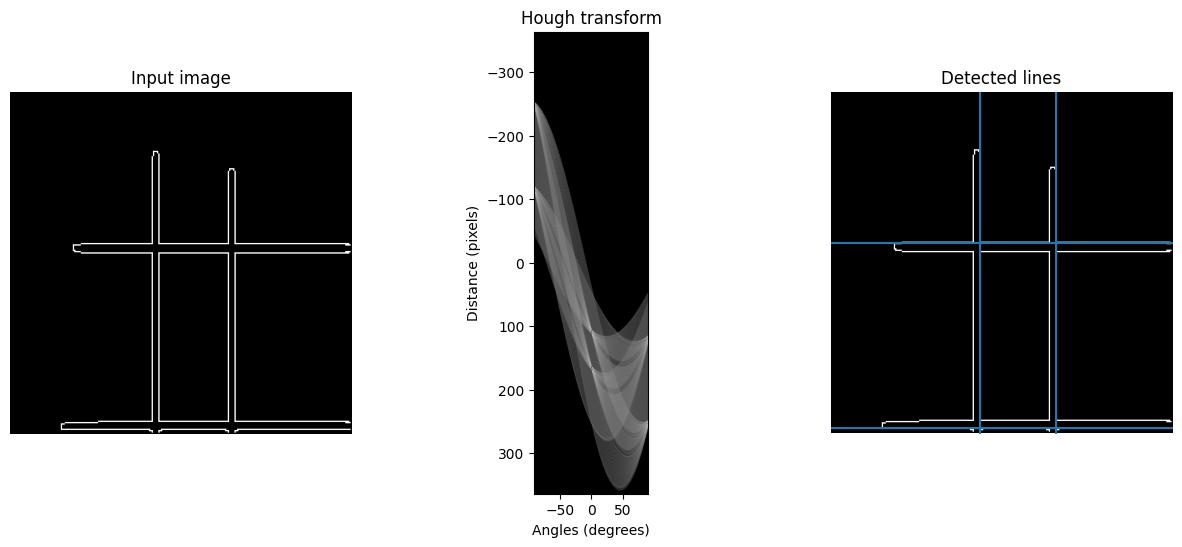

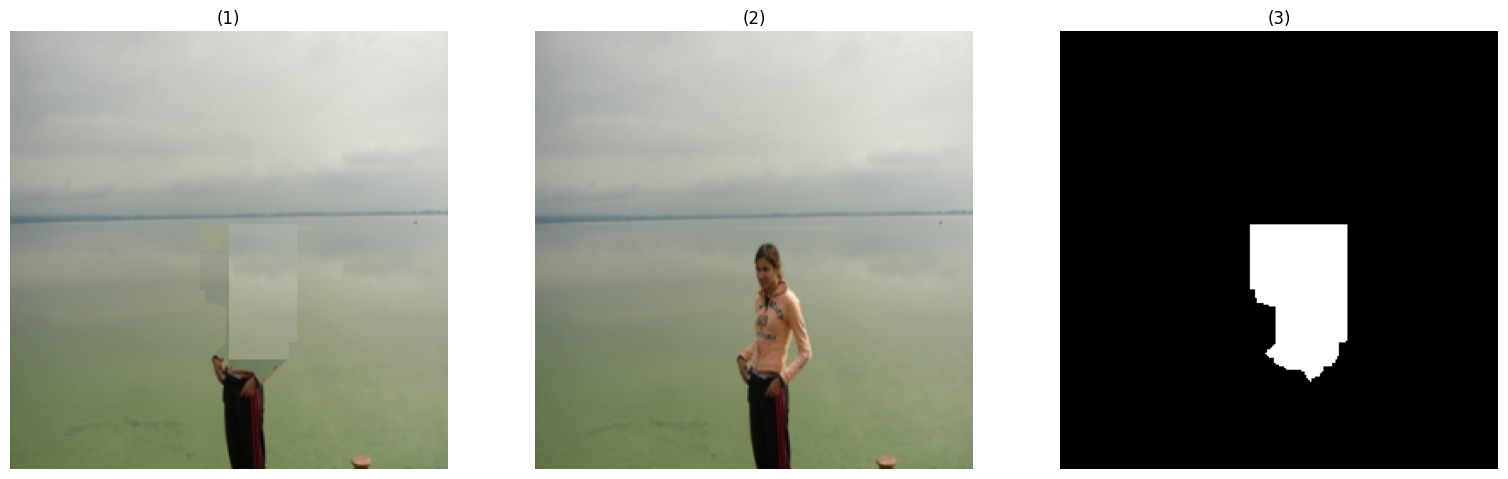

In [136]:
cow_select=io.imread('images-to-be-tested/womanSel.png')
cow_orig=io.imread('images-to-be-tested/woman.png')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,32,32)
show_images([newImg,grayLevelImg,   binary_mask_test])


Ratio of white to black pixels: 0.107940673828125
7
7
new_target_patches [[[228 227 233]
  [253 252 253]
  [246 244 254]
  ...
  [175 181 194]
  [168 174 190]
  [189 195 211]]

 [[249 249 252]
  [248 247 250]
  [242 240 247]
  ...
  [205 211 223]
  [154 160 174]
  [198 204 220]]

 [[249 248 252]
  [245 244 250]
  [249 247 254]
  ...
  [196 202 214]
  [150 156 170]
  [171 177 192]]

 ...

 [[ 96 134  64]
  [ 96 133  63]
  [ 96 133  63]
  ...
  [ 95 136  57]
  [ 92 133  53]
  [ 96 137  57]]

 [[118 155  85]
  [119 156  86]
  [120 157  87]
  ...
  [ 94 135  53]
  [ 89 130  49]
  [ 99 141  58]]

 [[117 154  84]
  [117 154  84]
  [115 152  82]
  ...
  [ 92 134  51]
  [ 81 123  41]
  [ 93 135  53]]]
[[[202 209 227]
  [233 240 249]
  [186 192 212]
  ...
  [244 242 245]
  [254 253 254]
  [246 245 249]]

 [[187 194 212]
  [171 178 196]
  [167 174 193]
  ...
  [249 248 250]
  [253 252 253]
  [236 235 240]]

 [[142 149 165]
  [169 176 194]
  [210 217 232]
  ...
  [247 246 249]
  [253 252 254]
  [

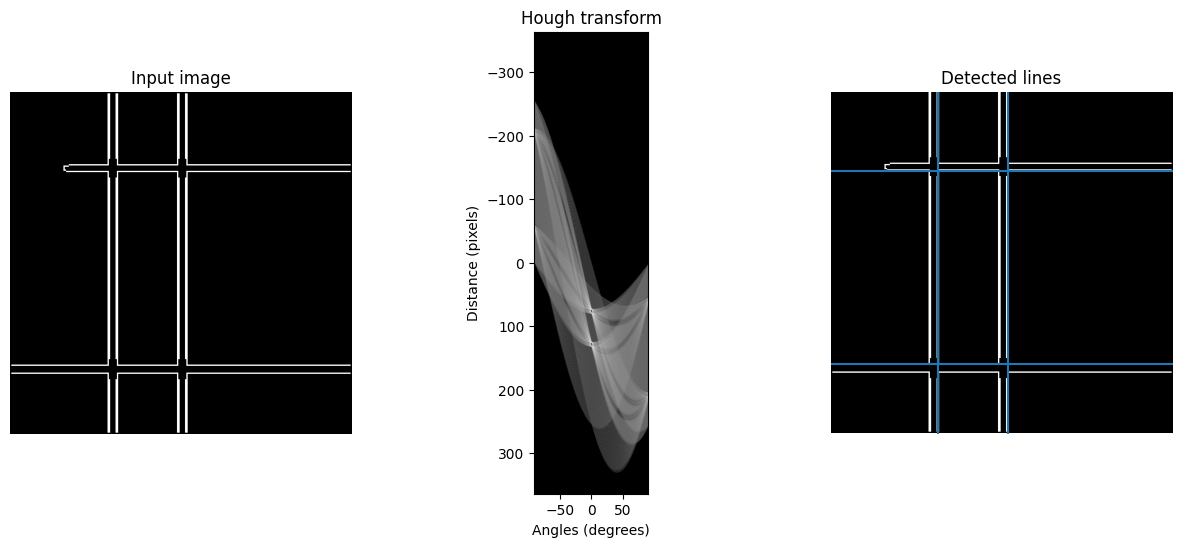

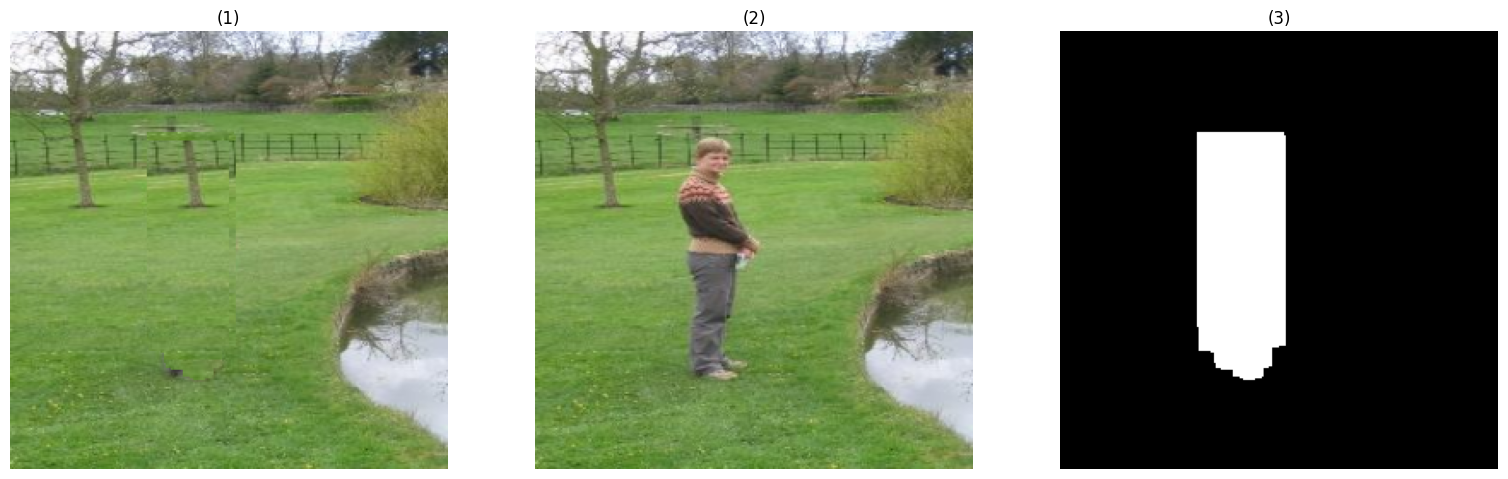

In [137]:
cow_select=io.imread('images-to-be-tested/guySel.png')
cow_orig=io.imread('images-to-be-tested/guy.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,32,32)
show_images([newImg,grayLevelImg,   binary_mask_test])


In [142]:
cow_select=io.imread('images-to-be-tested/sheeppsel.png')
cow_orig=io.imread('images-to-be-tested/sheep.jpg')

target_img_size = (256, 256)

cow_sel_resize = cv2.resize(cow_select, target_img_size)
cow_sel_conversion = cow_sel_resize[:,:,:3]
cow_resized_orig = cv2.resize(cow_orig[:,:,:3], target_img_size)


# # Create an instance of the RegionDetection overlap=32
region_detector_1 = RegionDetection(cow_resized_orig, cow_sel_conversion)
region_mask, binary_mask_test=region_detector_1.get_mask_by_region_detection()

binary_mask_test=binary_mask_test[:,:,0]

grayLevelImg = cow_resized_orig#(rgb2gray(cow_resized_orig)*255).astype('uint8')
white_pixels = np.sum(binary_mask_test == 1)
black_pixels = np.sum(binary_mask_test == 0)

# Calculate the ratio
ratio = white_pixels / (white_pixels + black_pixels)
print(f"Ratio of white to black pixels: {ratio}")

newImg= main(grayLevelImg,binary_mask_test,32,32)
show_images([newImg,grayLevelImg,   binary_mask_test])


FileNotFoundError: No such file: 'd:\senior 2 term 1\image processing\testing corner\regionDetection\images-to-be-tested\sheeppSel.png'